In [5]:
!pip -q install -U --no-deps pandas==2.2.2
!pip -q install -U pyarrow beautifulsoup4 lxml

In [17]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [18]:
EPUB_PATH = "/content/drive/MyDrive/juego_de_tronos.epub"

import os
assert os.path.exists(EPUB_PATH), f"No existe: {EPUB_PATH}"
print("OK:", EPUB_PATH)

OK: /content/drive/MyDrive/juego_de_tronos.epub


In [19]:
import zipfile
import re
import pandas as pd
from bs4 import BeautifulSoup


def clean_text(text: str) -> str:
    text = re.sub(r"\r\n?", "\n", text)
    text = re.sub(r"\n\s*\n+", "\n\n", text)
    text = re.sub(r"[ \t]+", " ", text)
    return text.strip()


def extract_title_and_pov(text: str):
    # Heurística para este EPUB: "DAENERYS (1)", "EDDARD (2)", etc.
    lines = [ln.strip() for ln in text.split("\n") if ln.strip()]
    for line in lines[:20]:
        if re.match(r"^[A-ZÁÉÍÓÚÑÜ]+.*\(\d+\)$", line):
            pov = line.split("(")[0].strip()
            return line, pov
    return None, None


def list_xhtml_text_files(z: zipfile.ZipFile):
    # Cubre EPUBs típicos con capítulos en /Text/ o /texto/
    candidates = [f for f in z.namelist() if f.lower().endswith((".xhtml", ".html"))]
    preferred = [f for f in candidates if "/text/" in f.lower() or "/texto/" in f.lower()]
    files = preferred if preferred else candidates
    return sorted(files)


def extract_chapters(epub_path: str) -> pd.DataFrame:
    chapters = []
    with zipfile.ZipFile(epub_path, "r") as z:
        text_files = list_xhtml_text_files(z)

        for file in text_files:
            raw = z.read(file)
            soup = BeautifulSoup(raw, "lxml")

            text = soup.get_text("\n")
            text = clean_text(text)

            # Filtrar cosas que no son capítulos (créditos/índice/etc.)
            if len(text) < 800:
                continue

            title, pov = extract_title_and_pov(text)

            chapters.append({
                "epub_file": file,
                "title": title,
                "pov": pov,
                "text": text,
                "n_chars": len(text),
            })

    df = pd.DataFrame(chapters).sort_values("epub_file").reset_index(drop=True)
    df["chapter_id"] = range(len(df))
    return df


chapters_df = extract_chapters(EPUB_PATH)
print("Chapters extracted:", len(chapters_df))
chapters_df.head(10)

/tmp/ipython-input-2276248545.py:39: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(raw, "lxml")


Chapters extracted: 84


,epub_file,title,pov,text,n_chars,chapter_id
0,OEBPS/Text/003.xhtml,None,None,"PRESENTACIÓN\n\nPRESENTACIÓN\n\nHielo y fuego,...",5404,0
1,OEBPS/Text/007.xhtml,None,None,PRÓLOGO\n\nPRÓLOGO\n\n—Deberíamos volver ya —i...,23200,1
2,OEBPS/Text/008.xhtml,BRAN (1),BRAN,BRAN (1)\n\nBRAN (1)\n\nEl día había amanecido...,18058,2
3,OEBPS/Text/009.xhtml,CATELYN (1),CATELYN,CATELYN (1)\n\nCATELYN (1)\n\nA Catelyn nunca ...,12594,3
4,OEBPS/Text/010.xhtml,DAENERYS (1),DAENERYS,DAENERYS (1)\n\nDAENERYS (1)\n\nSu hermano le ...,25712,4
5,OEBPS/Text/011.xhtml,EDDARD (1),EDDARD,EDDARD (1)\n\nEDDARD (1)\n\nLos visitantes ent...,22761,5
6,OEBPS/Text/012.xhtml,JON (1),JON,"JON (1)\n\nJON (1)\n\nHabía ocasiones, aunque ...",18922,6
7,OEBPS/Text/013.xhtml,CATELYN (2),CATELYN,CATELYN (2)\n\nCATELYN (2)\n\nDe todas las hab...,20345,7
8,OEBPS/Text/014.xhtml,ARYA (1),ARYA,ARYA (1)\n\nARYA (1)\n\nLas puntadas de Arya v...,15997,8
9,OEBPS/Text/015.xhtml,BRAN (2),BRAN,BRAN (2)\n\nBRAN (2)\n\nLa partida de caza se ...,22055,9


In [20]:
chapters_df.to_parquet("chapters.parquet", index=False)
print("Saved chapters.parquet")

Saved chapters.parquet


In [21]:
CHUNK_SIZE = 4500   # ~700-900 tokens típicamente (depende del texto)
OVERLAP = 750       # solape para continuidad

def chunk_text(text: str, chunk_size: int, overlap: int):
    assert chunk_size > overlap
    chunks = []
    start = 0
    n = len(text)

    while start < n:
        end = min(start + chunk_size, n)
        chunk = text[start:end].strip()
        if chunk:
            chunks.append((start, end, chunk))
        start += (chunk_size - overlap)

    return chunks


rows = []
for _, r in chapters_df.iterrows():
    parts = chunk_text(r["text"], CHUNK_SIZE, OVERLAP)
    for i, (start, end, chunk) in enumerate(parts):
        rows.append({
            "chunk_id": f'{int(r["chapter_id"])}_{i}',
            "chapter_id": int(r["chapter_id"]),
            "epub_file": r["epub_file"],
            "title": r["title"],
            "pov": r["pov"],
            "start_char": int(start),
            "end_char": int(end),
            "text": chunk,
            "n_chars": len(chunk),
        })

chunks_df = pd.DataFrame(rows)
print("Chunks:", len(chunks_df))
chunks_df.head(10)

Chunks: 509


,chunk_id,chapter_id,epub_file,title,pov,start_char,end_char,text,n_chars
0,0_0,0,OEBPS/Text/003.xhtml,None,None,0,4500,"PRESENTACIÓN\n\nPRESENTACIÓN\n\nHielo y fuego,...",4500
1,0_1,0,OEBPS/Text/003.xhtml,None,None,3750,5404,a aparición de la edición en\n paperback \nque...,1654
2,1_0,1,OEBPS/Text/007.xhtml,None,None,0,4500,PRÓLOGO\n\nPRÓLOGO\n\n—Deberíamos volver ya —i...,4500
3,1_1,1,OEBPS/Text/007.xhtml,None,None,3750,8250,bón.\n\n—Apuesto a que las mató a todas con su...,4500
4,1_2,1,OEBPS/Text/007.xhtml,None,None,7500,12000,durante un tiempo. Luego se mete dentro y empi...,4498
5,1_3,1,OEBPS/Text/007.xhtml,None,None,11250,15750,"dia de la Noche, y nunca había tenido tanto mi...",4500
6,1_4,1,OEBPS/Text/007.xhtml,None,None,15000,19500,ción—. No pienso fracasar en mi primera expedi...,4500
7,1_5,1,OEBPS/Text/007.xhtml,None,None,18750,23200,"azules que ningún ojo humano, de un azul que a...",4450
8,1_6,1,OEBPS/Text/007.xhtml,None,None,22500,23200,"el viejo oso Mormont, o el maestre Aemon. ¿Seg...",699
9,2_0,2,OEBPS/Text/008.xhtml,BRAN (1),BRAN,0,4500,BRAN (1)\n\nBRAN (1)\n\nEl día había amanecido...,4499


In [22]:
chunks_df.to_parquet("chunks.parquet", index=False)
print("Saved chunks.parquet")

Saved chunks.parquet


In [23]:
q = "Tyrion"
hits = chunks_df[chunks_df["text"].str.contains(q, case=False, na=False)]
print("Hits:", len(hits))
hits[["chunk_id", "pov", "title", "n_chars"]].head(10)

Hits: 110


,chunk_id,pov,title,n_chars
25,5_0,EDDARD,EDDARD (1),4500
33,6_1,JON,JON (1),4500
35,6_3,JON,JON (1),4500
36,6_4,JON,JON (1),3922
37,6_5,JON,JON (1),172
55,10_0,TYRION,TYRION (1),4500
56,10_1,TYRION,TYRION (1),4500
57,10_2,TYRION,TYRION (1),4500
58,10_3,TYRION,TYRION (1),1708
76,14_0,TYRION,TYRION (2),4500


In [24]:
!pip -q install -U faiss-cpu sentence-transformers transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 115.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 154.4 MB/s eta 0:00:00 0:00:01


In [25]:
import pandas as pd

chunks_df = pd.read_parquet("chunks.parquet")
print("Chunks loaded:", len(chunks_df))
chunks_df.head(3)

Chunks loaded: 509


,chunk_id,chapter_id,epub_file,title,pov,start_char,end_char,text,n_chars
0,0_0,0,OEBPS/Text/003.xhtml,None,None,0,4500,"PRESENTACIÓN\n\nPRESENTACIÓN\n\nHielo y fuego,...",4500
1,0_1,0,OEBPS/Text/003.xhtml,None,None,3750,5404,a aparición de la edición en\n paperback \nque...,1654
2,1_0,1,OEBPS/Text/007.xhtml,None,None,0,4500,PRÓLOGO\n\nPRÓLOGO\n\n—Deberíamos volver ya —i...,4500


In [26]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Modelo top multilingüe para retrieval
embed_model_id = "BAAI/bge-m3"
embedder = SentenceTransformer(embed_model_id)

# Importante: normalizar embeddings para usar coseno vía inner product
def embed_texts(texts, batch_size=32):
    vecs = embedder.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return vecs.astype("float32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [27]:
import faiss
import numpy as np

texts = chunks_df["text"].tolist()
emb = embed_texts(texts, batch_size=32)

dim = emb.shape[1]
index = faiss.IndexFlatIP(dim)  # inner product == coseno si está normalizado
index.add(emb)

print("FAISS index size:", index.ntotal)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

FAISS index size: 509


In [28]:
from sentence_transformers import CrossEncoder

reranker_id = "BAAI/bge-reranker-large"
reranker = CrossEncoder(reranker_id)

config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: BAAI/bge-reranker-large
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [29]:
import numpy as np

def retrieve(query: str, top_k: int = 8, faiss_k: int = 30):
    # 1) embed query
    q_emb = embed_texts([query], batch_size=1)
    
    # 2) FAISS search
    scores, idxs = index.search(q_emb, faiss_k)
    idxs = idxs[0].tolist()
    cand = chunks_df.iloc[idxs].copy()
    cand["faiss_score"] = scores[0]
    
    # 3) rerank (cross-encoder)
    pairs = [(query, t) for t in cand["text"].tolist()]
    rr_scores = reranker.predict(pairs)
    cand["rerank_score"] = rr_scores
    
    # 4) sort and return
    cand = cand.sort_values("rerank_score", ascending=False).head(top_k)
    
    # devolver columnas útiles
    return cand[["chunk_id", "chapter_id", "pov", "title", "faiss_score", "rerank_score", "text"]]

In [30]:
res = retrieve("¿Cómo escapó Tyrion del Nido de Águilas?", top_k=6, faiss_k=40)
res[["chunk_id","pov","title","rerank_score"]]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,chunk_id,pov,title,rerank_score
256,39_1,TYRION,TYRION (5),0.940271
132,22_4,TYRION,TYRION (3),0.728283
208,32_6,TYRION,TYRION (4),0.283094
427,63_11,TYRION,TYRION (8),0.178443
259,39_4,TYRION,TYRION (5),0.114959
419,63_3,TYRION,TYRION (8),0.038794


In [32]:
best = res.iloc[0]
print("BEST:", best["chunk_id"], "| POV:", best["pov"], "|", best["title"])
print()
print(best["text"][:4000])

BEST: 39_1 | POV: TYRION | TYRION (5)

l empujarlo hacia el interior de la celda—. Dentro de veinte días, o de treinta, o a lo mejor de cincuenta. Pero volarás.

Los Arryn contaban con la única mazmorra de todo el reino en la que se permitía a los prisioneros escapar cuando lo desearan. Aquel primer día, tras pasarse horas reuniendo el valor que le quedaba, Tyrion se tendió de bruces en el suelo y se arrastró hasta el borde para asomar la cabeza y mirar abajo. Divisó Cielo a unos doscientos metros en picado. Asomó la cabeza y la giró cuanto pudo, y vio otras celdas a la derecha y a la izquierda, y también sobre la suya. Estaba en una colmena de piedra, y le habían arrancado las alas.

En la celda hacía frío, el viento aullaba día y noche, y lo peor de todo era que el suelo estaba en pendiente. Una pendiente muy ligera, sí, pero más que suficiente. Tenía miedo de cerrar los ojos, de deslizarse rodando en sueños, y a menudo se despertaba aterrado ante la posibilidad de estar cayendo haci

In [33]:
!pip -q install -U transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 45.2 MB/s eta 0:00:00:00:0100:01


In [117]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "Qwen/Qwen3.5-397B-A17B"  # <-- MÁS CAÑA
# model_id = "Qwen/Qwen2.5-7B-Instruct"  # fallback si hiciera falta

bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb,
    torch_dtype=torch.float16,
)

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 94 files:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:768: UserWarning: Not enough free disk space to download the file. The expected file size is: 8589.93 MB. The target location /root/.cache/huggingface/hub/models--Qwen--Qwen3.5-397B-A17B/blobs only has 7014.54 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:768: UserWarning: Not enough free disk space to download the file. The expected file size is: 8589.93 MB. The target location /root/.cache/huggingface/hub/models--Qwen--Qwen3.5-397B-A17B/blobs only has 7036.46 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:768: UserWarning: Not enough free disk space to download the file. The expected file size is: 8589.93 MB. The target location /root/.cache/huggingface/hub/models--Qwen--Qwen3.5-397B-A17B/blobs only has 6960.96 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

RuntimeError: Data processing error: CAS service error : IO Error: No space left on device (os error 28)

In [57]:
def ask(question: str, top_k: int = 12, faiss_k: int = 100, preview: bool = True):
    """
    Pregunta general sobre el Libro 1.
    - retrieval (FAISS) + rerank
    - respuesta grounded con qa_general()
    """
    # sanity checks
    assert "chunks_df" in globals(), "Falta chunks_df"
    assert "embed_texts" in globals(), "Falta embed_texts()"
    assert "index" in globals(), "Falta index (FAISS)"
    assert "reranker" in globals(), "Falta reranker"
    assert "qa_general" in globals(), "Falta qa_general()"
    
    # ---- retrieve general ----
    q_emb = embed_texts([question], batch_size=1)
    scores, idxs = index.search(q_emb, faiss_k)
    
    rows = []
    for s, i in zip(scores[0].tolist(), idxs[0].tolist()):
        r = chunks_df.iloc[i].to_dict()
        r["faiss_score"] = float(s)
        rows.append(r)
    
    import pandas as pd
    cand = pd.DataFrame(rows)
    
    pairs = [(question, t) for t in cand["text"].tolist()]
    cand["rerank_score"] = reranker.predict(pairs)
    passages = cand.sort_values("rerank_score", ascending=False).head(top_k)[
        ["chunk_id","chapter_id","pov","title","faiss_score","rerank_score","text"]
    ].reset_index(drop=True)

    # ---- answer ----
    answer = qa_general(question, passages)

    if preview:
        display(passages[["chunk_id","pov","title","rerank_score"]].head(min(top_k, 10)))

    return answer, passages

In [58]:
question = "¿Cómo escapó Tyrion del Nido de Águilas?"
passages = ask(question, top_k=10, faiss_k=80)
passages[["chunk_id","pov","title","rerank_score"]]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,chunk_id,pov,title,rerank_score
0,39_1,TYRION,TYRION (5),0.940271
1,22_4,TYRION,TYRION (3),0.728283
2,32_3,TYRION,TYRION (4),0.699657
3,63_2,TYRION,TYRION (8),0.356095
4,51_2,ARYA,ARYA (4),0.338079
5,71_1,JON,JON (9),0.329795
6,32_6,TYRION,TYRION (4),0.283094
7,32_2,TYRION,TYRION (4),0.220660
8,63_11,TYRION,TYRION (8),0.178443
9,41_4,CATELYN,CATELYN (7),0.120725


TypeError: tuple indices must be integers or slices, not list

In [59]:
import torch

def build_context(passages_df, max_chars_each=2200):
    blocks = []
    for _, r in passages_df.iterrows():
        cid = r["chunk_id"]
        pov = r["pov"]
        title = r["title"]
        txt = r["text"].strip()[:max_chars_each]
        blocks.append(f"[{cid}] ({pov} | {title})\n{txt}")
    return "\n\n".join(blocks)


def qa_general(question: str, passages_df, max_new_tokens=420):
    context = build_context(passages_df, max_chars_each=2200)

    system = (
        "Eres un asistente de preguntas y respuestas sobre el libro 'Juego de Tronos' (Libro 1). "
        "Debes responder ÚNICAMENTE con la información que aparece en los fragmentos proporcionados. "
        "Si la respuesta no se puede deducir de esos fragmentos, di exactamente: "
        "'No encontrado en los fragmentos proporcionados'. "
        "No inventes nombres, lugares, acciones, ni detalles.\n\n"
        "Formato obligatorio:\n"
        "- Español.\n"
        "- 4 a 10 frases.\n"
        "- Cita fuentes con [chunk_id] al final de cada frase con hechos.\n"
        "- Última línea: 'Fuentes: [id1], [id2], ...'."
    )

    user = (
        f"Pregunta: {question}\n\n"
        f"Fragmentos:\n{context}\n\n"
        "Tarea: Responde de forma clara y fiel al texto."
    )

    messages = [
        {"role":"system","content":system},
        {"role":"user","content":user},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,     # clave anti-alucinación
        temperature=0.0,
        top_p=1.0,
        repetition_penalty=1.05,
    )

    return tokenizer.decode(out[0], skip_special_tokens=True).strip()

In [73]:
ans, passages = ask("¿Qué frase le dice Tyrion a Jon Nieve de camino al muro? Algo sobre enanos")
print(ans)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,chunk_id,pov,title,rerank_score
0,22_6,TYRION,TYRION (3),0.928752
1,20_5,JON,JON (3),0.872962
2,20_6,JON,JON (3),0.855298
3,14_4,TYRION,TYRION (2),0.816000
4,14_3,TYRION,TYRION (2),0.800779
5,20_1,JON,JON (3),0.709880
6,27_3,JON,JON (4),0.648723
7,14_5,TYRION,TYRION (2),0.610052
8,22_4,TYRION,TYRION (3),0.549176
9,14_1,TYRION,TYRION (2),0.542034


system
Eres un asistente de preguntas y respuestas sobre el libro 'Juego de Tronos' (Libro 1). Debes responder ÚNICAMENTE con la información que aparece en los fragmentos proporcionados. Si la respuesta no se puede deducir de esos fragmentos, di exactamente: 'No encontrado en los fragmentos proporcionados'. No inventes nombres, lugares, acciones, ni detalles.

Formato obligatorio:
- Español.
- 4 a 10 frases.
- Cita fuentes con [chunk_id] al final de cada frase con hechos.
- Última línea: 'Fuentes: [id1], [id2], ...'.
user
Pregunta: ¿Qué frase le dice Tyrion a Jon Nieve de camino al muro? Algo sobre enanos

Fragmentos:
[22_6] (TYRION | TYRION (3))
o, Lord Nieve. Prestaré a Bran la poca ayuda que esté en mi mano.

—Gracias, mi señor de Lannister. —Se quitó el guante y le tendió la mano desnuda—. Amigo mío.

Tyrion se sintió extrañamente conmovido.

—La mayor parte de mis parientes son bastardos —dijo con una sonrisa irónica—, pero eres el primero al que me une la amistad. —Se quitó el gu

In [72]:
!pip -q install -U diffusers transformers accelerate safetensors huggingface_hub

In [74]:
import torch
from huggingface_hub import hf_hub_download
from diffusers import StableDiffusionXLPipeline, AutoencoderKL

# Descarga checkpoint single-file Juggernaut XL v9
ckpt_path = hf_hub_download(
    repo_id="RunDiffusion/Juggernaut-XL-v9",
    filename="Juggernaut-XL_v9_RunDiffusionPhoto_v2.safetensors",
)

# VAE fp16 fix (mejor estabilidad/calidad)
vae = AutoencoderKL.from_pretrained(
    "madebyollin/sdxl-vae-fp16-fix",
    torch_dtype=torch.float16
)

pipe = StableDiffusionXLPipeline.from_single_file(
    ckpt_path,
    vae=vae,
    torch_dtype=torch.float16,
).to("cuda")

# Optimizaciones memoria
pipe.enable_attention_slicing()

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Juggernaut-XL_v9_RunDiffusionPhoto_v2.sa(…):   0%|          | 0.00/7.11G [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [111]:
import json
import re
import torch


# ============================================================
# 1) SCENE SCHEMA (planner output)
# ============================================================
SCENE_SCHEMA = {
  "shot_type": "portrait|establishing|action|dialogue|symbolic",
  "location": "string",
  "time_of_day": "day|night|dawn|dusk|unknown",
  "weather": "string",
  "mood": "string",
  "characters": [
    {
      "name": "string (from book if possible)",
      "visual_description": "string (no actor names, no TV references)",
      "wardrobe": "string"
    }
  ],
  "action": "string (1 sentence)",
  "key_props": ["string", "..."],
  "composition": "string (camera, framing, lens, angle)",
  "constraints": ["string", "..."]
}


# ============================================================
# 2) Robust JSON extraction (fixes Extra data)
# ============================================================
def _extract_first_json_object(s: str) -> str:
    """
    Extract the first balanced {...} JSON object from a string.
    Ignores any extra text before/after.
    """
    start = s.find("{")
    if start == -1:
        raise ValueError("No '{' found in planner output")

    depth = 0
    in_str = False
    esc = False

    for i in range(start, len(s)):
        ch = s[i]

        # handle strings to avoid counting braces inside quotes
        if in_str:
            if esc:
                esc = False
            elif ch == "\\":
                esc = True
            elif ch == '"':
                in_str = False
            continue
        else:
            if ch == '"':
                in_str = True
                continue

        if ch == "{":
            depth += 1
        elif ch == "}":
            depth -= 1
            if depth == 0:
                return s[start:i+1]

    raise ValueError("Unbalanced braces in planner output")


# ============================================================
# 3) Planner: (question + retrieved passages) -> scene JSON
# ============================================================
def plan_scene_json(question: str, passages_df, max_chars_each: int = 2000, debug: bool = False) -> dict:
    """
    Uses Qwen Instruct to produce a single JSON object describing the scene.
    Output is parsed robustly (handles extra text).
    """
    # Build context from passages
    blocks = []
    for _, r in passages_df.iterrows():
        cid = r.get("chunk_id", "")
        txt = (r.get("text", "") or "").strip()[:max_chars_each]
        blocks.append(f"[{cid}]\n{txt}")
    context = "\n\n".join(blocks)

    system = (
        "You are a scene planner for generating an image based on a novel (Spanish text). "
        "Return ONLY a valid JSON object that follows the provided schema. "
        "Use only information supported by the provided excerpts. "
        "If the question is definitional (e.g. '¿Quién es X?'), plan a coherent portrait or establishing shot "
        "without inventing specific events. "
        "Forbidden: TV show references, actor names, celebrity likeness.\n"
        "Return ONLY JSON. No markdown, no code fences, no commentary."
    )

    user = (
        f"Pregunta: {question}\n\n"
        f"Fragmentos:\n{context}\n\n"
        f"Schema JSON:\n{json.dumps(SCENE_SCHEMA, ensure_ascii=False)}\n\n"
        "Devuelve SOLO el JSON."
    )

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": user},
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    out = model.generate(
        **inputs,
        max_new_tokens=500,
        do_sample=False,
        temperature=0.0,
        top_p=1.0,
        repetition_penalty=1.05,
    )

    raw = tokenizer.decode(out[0], skip_special_tokens=True).strip()

    if debug:
        print("=== PLANNER RAW (first 1200 chars) ===")
        print(raw[:1200])
        print("=== END RAW ===")

    js = _extract_first_json_object(raw)

    # Parse
    return json.loads(js)


# ============================================================
# 4) Convert scene JSON -> SDXL prompt (generic, no hardcoded scenes)
# ============================================================
def scene_json_to_sdxl_prompt(scene: dict):
    """
    Builds a SHORT, CLIP-optimized prompt (<77 tokens effective)
    prioritizing visual information only.
    """

    base = "cinematic film still, medieval fantasy, ultra detailed, realistic lighting"

    # ---- characters (limit hard) ----
    chars = []
    for c in (scene.get("characters") or [])[:2]:
        name = (c.get("name") or "").strip()
        vd = (c.get("visual_description") or "").strip()
        wd = (c.get("wardrobe") or "").strip()

        part = ", ".join([p for p in [name, vd, wd] if p])
        if part:
            chars.append(part)

    chars_txt = "; ".join(chars)

    # ---- key visual fields only ----
    loc  = (scene.get("location") or "").strip()
    act  = (scene.get("action") or "").strip()
    mood = (scene.get("mood") or "").strip()
    tod  = (scene.get("time_of_day") or "").strip()

    # composition (shortened aggressively)
    comp = (scene.get("composition") or "")
    comp = comp.split(",")[0] if comp else ""

    # ---- assemble prompt (minimal, visual only) ----
    parts = [
        base,
        act,
        f"location: {loc}" if loc else "",
        f"characters: {chars_txt}" if chars_txt else "",
        f"{mood} mood" if mood else "",
        tod,
        comp,
    ]

    prompt = ", ".join([p for p in parts if p])

    # ---- negative prompt short ----
    negative = (
        "cartoon, anime, illustration, low quality, blurry, watermark, text, logo, modern clothing, sci-fi"
    )

    return prompt, negative


# ============================================================
# 5) End-to-end: question -> QA -> planner -> SDXL -> image
# ============================================================
def ask_and_draw_any(question: str, top_k: int = 10, faiss_k: int = 80, seed: int | None = None, debug_planner: bool = False):
    """
    Uses your existing ask() for retrieval+answer, then plans an image scene via Qwen, then generates SDXL image.
    Returns: (answer_text, image, passages_df, scene_json)
    """
    # 1) QA + passages
    answer, passages = ask(question, top_k=top_k, faiss_k=faiss_k, preview=True)

    # 2) Plan scene (JSON)
    scene = plan_scene_json(question, passages, debug=debug_planner)

    # 3) Build SDXL prompt
    prompt, negative = scene_json_to_sdxl_prompt(scene)

    # 4) Generate image
    gen_kwargs = dict(
        prompt=prompt,
        negative_prompt=negative,
        width=1216,
        height=832,
        num_inference_steps=35,
        guidance_scale=5.5
    )

    if seed is not None:
        gen_kwargs["generator"] = torch.Generator("cuda").manual_seed(seed)

    img = pipe(**gen_kwargs).images[0]

    print("SCENE_JSON:", scene)
    print("\nPROMPT:\n", prompt)

    return answer, img, passages, scene

In [112]:
def scene_json_to_sdxl_prompt(scene: dict):
    """
    Builds a SHORT, CLIP-optimized prompt (<77 tokens effective)
    prioritizing visual information only.
    """

    base = "cinematic film still, medieval fantasy, ultra detailed, realistic lighting"

    # ---- characters (limit hard) ----
    chars = []
    for c in (scene.get("characters") or [])[:2]:
        name = (c.get("name") or "").strip()
        vd = (c.get("visual_description") or "").strip()
        wd = (c.get("wardrobe") or "").strip()

        part = ", ".join([p for p in [name, vd, wd] if p])
        if part:
            chars.append(part)

    chars_txt = "; ".join(chars)

    # ---- key visual fields only ----
    loc  = (scene.get("location") or "").strip()
    act  = (scene.get("action") or "").strip()
    mood = (scene.get("mood") or "").strip()
    tod  = (scene.get("time_of_day") or "").strip()

    # composition (shortened aggressively)
    comp = (scene.get("composition") or "")
    comp = comp.split(",")[0] if comp else ""

    # ---- assemble prompt (minimal, visual only) ----
    parts = [
        base,
        act,
        f"location: {loc}" if loc else "",
        f"characters: {chars_txt}" if chars_txt else "",
        f"{mood} mood" if mood else "",
        tod,
        comp,
    ]

    prompt = ", ".join([p for p in parts if p])

    # ---- negative prompt short ----
    negative = (
        "cartoon, anime, illustration, low quality, blurry, watermark, text, logo, modern clothing, sci-fi"
    )

    return prompt, negative

In [113]:
import torch

def ask_and_draw_any(question: str, top_k: int = 10, faiss_k: int = 80, seed: int | None = None):
    # 1) QA + passages (tu ask() actual)
    answer, passages = ask(question, top_k=top_k, faiss_k=faiss_k, preview=True)

    # 2) Plan escena (sin hardcode)
    scene = plan_scene_json(question, passages)

    # 3) Prompt SDXL
    prompt, negative = scene_json_to_sdxl_prompt(scene)

    gen_kwargs = dict(
        prompt=prompt,
        negative_prompt=negative,
        width=1216,
        height=832,
        num_inference_steps=35,
        guidance_scale=5.5
    )
    if seed is not None:
        gen_kwargs["generator"] = torch.Generator("cuda").manual_seed(seed)

    img = pipe(**gen_kwargs).images[0]

    print("SCENE_JSON:", scene)
    print("\nPROMPT:\n", prompt)
    return answer, img, passages, scene

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,chunk_id,pov,title,rerank_score
0,76_0,None,None,0.431698
1,10_0,TYRION,TYRION (1),0.359439
2,5_0,EDDARD,EDDARD (1),0.252595
3,6_1,JON,JON (1),0.121350
4,14_0,TYRION,TYRION (2),0.115281
5,43_0,TYRION,TYRION (6),0.067136
6,32_0,TYRION,TYRION (4),0.048522
7,19_6,CATELYN,CATELYN (4),0.044176
8,39_0,TYRION,TYRION (5),0.036258
9,39_1,TYRION,TYRION (5),0.034875


  0%|          | 0/35 [00:00<?, ?it/s]

SCENE_JSON: {'shot_type': 'portrait|establishing|action|dialogue|symbolic', 'location': 'string', 'time_of_day': 'day|night|dawn|dusk|unknown', 'weather': 'string', 'mood': 'string', 'characters': [{'name': 'string (from book if possible)', 'visual_description': 'string (no actor names, no TV references)', 'wardrobe': 'string'}], 'action': 'string (1 sentence)', 'key_props': ['string', '...'], 'composition': 'string (camera, framing, lens, angle)', 'constraints': ['string', '...']}

PROMPT:
 cinematic film still, medieval fantasy, ultra detailed, realistic lighting, string (1 sentence), location: string, characters: string (from book if possible), string (no actor names, no TV references), string, string mood, day|night|dawn|dusk|unknown, string (camera
system
Eres un asistente de preguntas y respuestas sobre el libro 'Juego de Tronos' (Libro 1). Debes responder ÚNICAMENTE con la información que aparece en los fragmentos proporcionados. Si la respuesta no se puede deducir de esos fragm

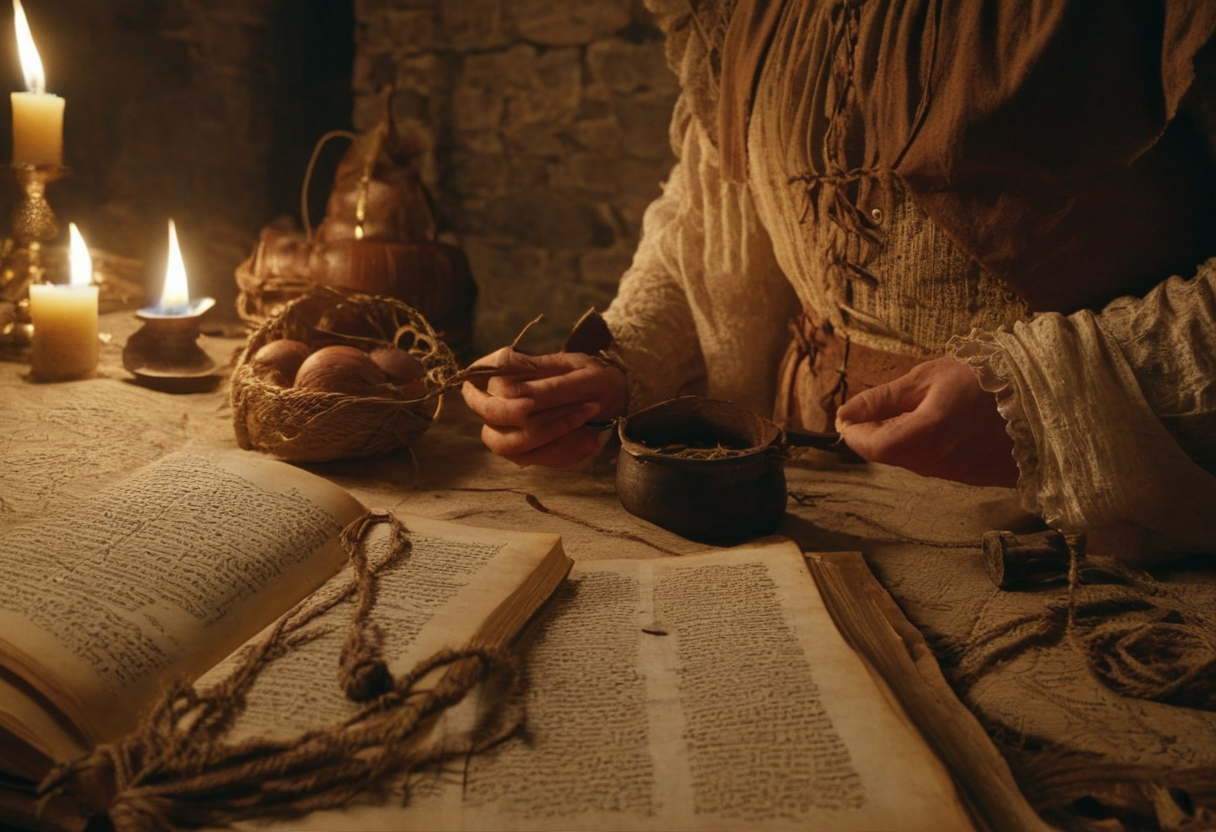

In [116]:
ans, img, passages, scene = ask_and_draw_any("¿Cómo es Tyrion Lannister?", seed=7)
print(ans)
img
img